In [1]:
import os
import tensorflow.compat.v1 as tf
import math
import numpy as np
import itertools
import math
import uuid
import time
import sys

from matplotlib import cm
import matplotlib.animation as animation
import matplotlib.pyplot as plt

from IPython.display import HTML
import itertools
import tensorflow as tf

from waymo_open_dataset.protos import scenario_pb2

In [2]:
FILENAME = '../data/scenario/uncompressed_scenario_training_20s_training_20s.tfrecord-00000-of-01000'
dataset = tf.data.TFRecordDataset(FILENAME)
scenario_data = []
for data in dataset:
    proto_string = data.numpy()
    proto = scenario_pb2.Scenario()
    proto.ParseFromString(proto_string)
    scenario_data.append(proto)

In [3]:
total_map = list(scenario_data[4].map_features)

In [4]:
def create_waypoints(points):
    result = []
    
    for p in points:
        holder = []
        tmp = str(p).split("\n")
        p_x = tmp[0].split(" ")
        holder.append(p_x[1])
        p_y = tmp[1].split(" ")
        holder.append(p_y[1])
        p_z = tmp[2].split(" ")
        holder.append(p_z[1])
        result.append(np.array(holder).astype("float32"))
    
    return np.array(result)


def plot_lines(lines):
    point_list = np.array(lines[0])
    for x in range(1,len(lines)):
        if not len(lines[x]) == 0:
            point_list = np.concatenate((point_list, np.array(lines[x])))
    
    point_list = np.array(point_list[:,:2].T).astype("float32")
    plt.plot(point_list[0,:], point_list[1,:], '.k',alpha=1, ms=0.5)
    

def plot_graph(road_graph):
    point_list = np.array(road_graph[0][1])
    for x in range(1,len(road_graph)):
        if not len(road_graph[x][1]) == 0:
            point_list = np.concatenate((point_list, np.array(road_graph[x][1])))
    
    point_list = np.array(point_list[:,:2].T).astype("float32")
    plt.plot(point_list[0,:], point_list[1,:], '.k',alpha=1, ms=0.5)

    
def plot_total_roadgraph(lane_graph, line_graph, edge_graph, x_dim, y_dim):
    lane_list = np.array(lane_graph[0][1])
    line_list = np.array(line_graph[0][1])
    edge_list = np.array(edge_graph[0][1])
    
    for x in range(1,len(lane_graph)):
        if not len(lane_graph[x][1]) == 0:
            lane_list = np.concatenate((lane_list, np.array(lane_graph[x][1])))
    for x in range(1,len(line_graph)):
        if not len(line_graph[x][1]) == 0:
            line_list = np.concatenate((line_list, np.array(line_graph[x][1])))
    for x in range(1,len(edge_graph)):
        if not len(edge_graph[x][1]) == 0:
            edge_list = np.concatenate((edge_list, np.array(edge_graph[x][1])))
    
    lane_list = np.array(lane_list[:,:2].T).astype("float32")
    line_list = np.array(line_list[:,:2].T).astype("float32")
    edge_list = np.array(edge_list[:,:2].T).astype("float32")
    
    plt.plot(lane_list[0,:], lane_list[1,:], '.k',alpha=1, ms=0.5)
    plt.plot(line_list[0,:], line_list[1,:], '.r',alpha=1, ms=0.5)
    plt.plot(edge_list[0,:], edge_list[1,:], '.b',alpha=1, ms=0.5)
    if not x_dim == None and not y_dim == None:
        plt.xlim(x_dim)
        plt.ylim(y_dim)
    plt.show()

In [5]:
   '''
    ## Lane ###
    [id,[waypoints], speedlimit, lanetype, interpolating]
    TYPE_UNDEFINED = 0;
    TYPE_FREEWAY = 1;
    TYPE_SURFACE_STREET = 2;
    TYPE_BIKE_LANE = 3;
    interpolating = true,false

    ## Road_line ###
    [id,[waypoints], lanetype]
    TYPE_UNKNOWN = 0;
    TYPE_BROKEN_SINGLE_WHITE = 1;
    TYPE_SOLID_SINGLE_WHITE = 2;
    TYPE_SOLID_DOUBLE_WHITE = 3;
    TYPE_BROKEN_SINGLE_YELLOW = 4;
    TYPE_BROKEN_DOUBLE_YELLOW = 5;
    TYPE_SOLID_SINGLE_YELLOW = 6;
    TYPE_SOLID_DOUBLE_YELLOW = 7;
    TYPE_PASSING_DOUBLE_YELLOW = 8;

    ## Road_edge ###
    [id,[waypoints], lanetype]
    TYPE_UNKNOWN = 0;
    TYPE_ROAD_EDGE_BOUNDARY = 1;
    TYPE_ROAD_EDGE_MEDIAN = 2;
    '''
def create_road_graph(total_map):
    lane_graph = []
    line_graph = []
    edge_graph = []
    
    for x in range(len(total_map)):
        chunk = total_map[x]
        
        if not str(chunk.lane) == "":   
            lane = []
            lane.append(chunk.id)
        
            poly_list = chunk.lane.polyline
            lane_point_list = create_waypoints(poly_list)
            lane.append(lane_point_list)
        
            lane.append(chunk.lane.speed_limit_mph)
            lane.append(chunk.lane.type)
            lane.append(chunk.lane.interpolating)
        
            lane_graph.append(lane)
        
        elif not str(chunk.road_line) == "":
            line = []
            line.append(chunk.id)
        
            poly_list = chunk.road_line.polyline
            line_point_list = create_waypoints(poly_list)
            line.append(line_point_list)

            line.append(chunk.road_line.type)
        
            line_graph.append(line)
    
        elif not str(chunk.road_edge) == "":
            edge = []
            edge.append(chunk.id)
        
            poly_list = chunk.road_edge.polyline
            edge_point_list = create_waypoints(poly_list)
            edge.append(edge_point_list)
        
            edge.append(chunk.road_edge.type)
        
            edge_graph.append(edge)

    return np.array(lane_graph), np.array(line_graph), np.array(edge_graph)

In [6]:
total_map = list(scenario_data[5].map_features)
lane_graph, line_graph, edge_graph = create_road_graph(total_map)

<ipython-input-5-83db05ace8d1>:74: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(lane_graph), np.array(line_graph), np.array(edge_graph)


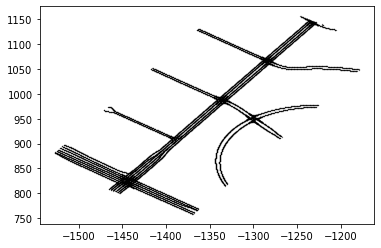

In [7]:
plot_graph(lane_graph)

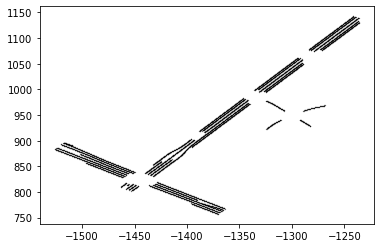

In [8]:
plot_graph(line_graph)

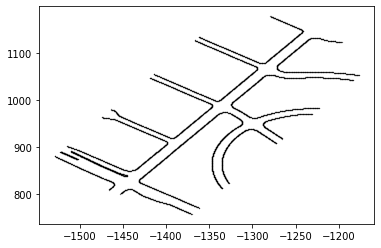

In [9]:
plot_graph(edge_graph)

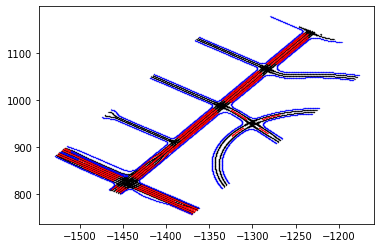

In [10]:
plot_total_roadgraph(lane_graph, line_graph, edge_graph, None, None)

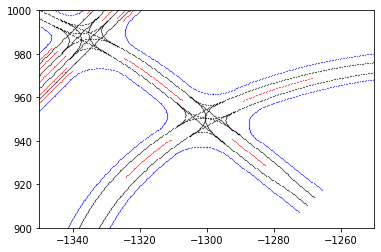

In [11]:
plot_total_roadgraph(lane_graph, line_graph, edge_graph, [-1350, -1250], [900, 1000])

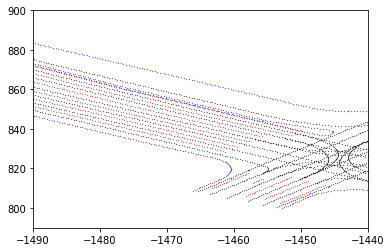

In [12]:
plot_total_roadgraph(lane_graph, line_graph, edge_graph, [-1490, -1440], [790, 900])

In [13]:
def calc_start_end_point(id_list, lane_list):
    start_point = [0,0]
    end_point = [0,0]
    index = id_list[0][0]
    
    for lane in lane_list:
        if index == lane[0]:
            if id_list[0][1] == 0:
                start_point = lane[1][0,:2]
            else:
                start_point = lane[1][-1,:2]
    
    index = id_list[-1][0]
    for lane in lane_list:
        if index == lane[0]:
            if id_list[0][1] == 0:
                end_point = lane[1][-1,:2]
            else:
                end_point = lane[1][0,:2]
    
    return np.array(abs(start_point)), np.array(abs(end_point))

def id_list_to_point_list(id_list, lane_graph):
    point_list = np.array([[0,0,0]])
    for x in range(len(id_list)):
        index = id_list[x][0]
        for lane in lane_graph:
            if lane[0] == index:
                if id_list[x][1] == 0:
                    point_list = np.concatenate((point_list, lane[1]))
                else:
                    flipped_lane = np.flip(lane[1], 0)
                    point_list = np.concatenate((point_list, flipped_lane))
                break
    return np.array(point_list[1:])


def plot_graph_with_lane(road_graph, lane):
    marked_lane = lane
    marked_lane = marked_lane[:,:2].T
    
    point_list = np.array(road_graph[0][1])
    for x in range(1,len(road_graph)):
        if not len(road_graph[x][1]) == 0:
            point_list = np.concatenate((point_list, np.array(road_graph[x][1])))
    
    point_list = np.array(point_list[:,:2].T).astype("float32")
    plt.plot(point_list[0,:], point_list[1,:], '.k',alpha=1, ms=0.5)
    plt.plot(marked_lane[0,:], marked_lane[1,:], '.r',alpha=1, ms=2.5)


In [14]:
def concat_lanes(lane_graph):
    mock = np.array(lane_graph)

    lane_id_list = []
    search_space = 0.1

    while not len(mock) == 0:
        entry = mock[0]
        mock = np.delete(mock, 0, 0)
        id_list = np.array([[entry[0],0]])

        appended_something = True
        
        while(appended_something):
            appended_something = False
            
            point_first, point_last = calc_start_end_point(id_list, lane_graph)
            
            for k in range(len(mock)):
                lane = mock[k]
                p_first = abs(lane[1][0, :2])
                p_last = abs(lane[1][-1, :2])
#                 print(abs(point_first[0] - p_first[0]))
                if abs(point_first[0] - p_first[0]) < search_space and abs(point_first[1] - p_first[1]) < search_space:
                    list_element = np.array([[lane[0], 1]])
                    id_list = np.concatenate((list_element,id_list))
                    appended_something = True
                elif abs(point_first[0] - p_last[0]) < search_space and abs(point_first[1] - p_last[1]) < search_space:
                    list_element = np.array([[lane[0], 0]])
                    id_list = np.concatenate((list_element,id_list))
                    appended_something = True
                elif abs(point_last[0] - p_last[0]) < search_space and abs(point_last[1] - p_last[1]) < search_space:
                    list_element = np.array([[lane[0], 1]])
                    id_list = np.concatenate((id_list, list_element))
                    appended_something = True
                elif abs(point_last[0] - p_first[0]) < search_space and abs(point_last[1] - p_first[1]) < search_space:
                    list_element = np.array([[lane[0], 0]])
                    id_list = np.concatenate((id_list, list_element))
                    appended_something = True
                
                if appended_something:
                    mock = np.delete(mock, k, 0)
                    break
        lane_id_list.append(np.array(id_list))
    return np.array(lane_id_list)

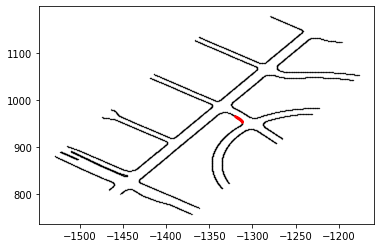

In [15]:
# polylines that follow another polyline are denoted not explicitly
plot_graph_with_lane(edge_graph, edge_graph[28][1])

In [16]:
# concat_lanes does is a rough idea of a workaround
edge_list = concat_lanes(edge_graph)

<ipython-input-14-f13fc49e020e>:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(lane_id_list)


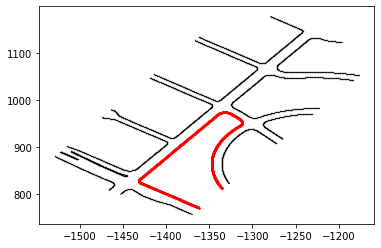

In [17]:
# concat_lanes works on edge_graph 
edge = id_list_to_point_list(edge_list[5], edge_graph)
plot_graph_with_lane(edge_graph, edge)

In [18]:
lane_list = concat_lanes(lane_graph)

<ipython-input-14-f13fc49e020e>:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(lane_id_list)


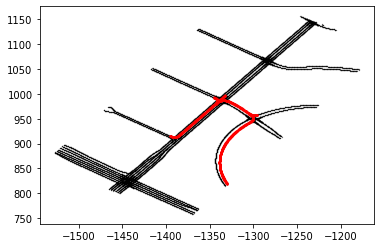

In [19]:
# concat_lanes fails on lane_graph 
lane = id_list_to_point_list(lane_list[14], lane_graph)
plot_graph_with_lane(lane_graph, lane)

In [20]:
### if issues above are solved -> save to osm(lanelet)

# sys.path.insert(1, '../python_scripts/') 
# from XML_Parser import XML_Parser as parser

# tmp = np.array([list_of_lanes])
# parser.points_to_xml(tmp, "road")